# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

In [150]:
class TreeNode:
    def predict(self, x): raise NotImplementedError

class Leaf(TreeNode):
    def __init__(self, value, class_counts=None, n_samples=None): 
        self.value = value
        self.class_counts = class_counts
        self.n_samples = n_samples
    def predict(self, x): return self.value

class Node(TreeNode):
    def __init__(self, feature_idx, threshold, is_categorical, categories, left: TreeNode, right: TreeNode, n_samples, impurity):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.is_categorical = is_categorical
        self.categories = categories
        self.left = left
        self.right = right
    def predict(self, x):
        if self.is_categorical:
            branch = self.left if x[self.feature_idx] in self.categories else self.right
        else:
            branch = self.left if x[self.feature_idx] <= self.threshold else self.right
        return branch.predict(x)

In [151]:
def is_pure(labels) -> bool:
    return np.unique_values(labels).size == 1

def reached_max_depth(depth, max_depth) -> bool:
    return depth >= max_depth

def reached_min_node_size(data) -> bool:
    return data.shape[0] < 5

# Add more stopping criterias if needed. Don't forget to use them when growing the tree!

### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achived by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [152]:
# Thought this should be for both classification and regression
# Noticed too late we only needed classification

def select_splitting_feature(features, labels, idxs, class_map=None):
    # store best feature in tuple[index, gini score]
    best_split = None
    best_score = -np.inf

    # iterate over all features
    for feature_index in range(features.shape[1]):
        feature = features[idxs,feature_index]
        y = labels[idxs]

        if class_map is not None:
            y = np.array([class_map[label] for label in y])
        else:
            y = labels[idxs]

        # feature is categorical
        if features[:, feature_index].dtype == "O":
            # assign left and right feature and nodes
            split_value = feature[0]
            left_mask = feature == split_value
            right_mask = ~left_mask

            # calculate class distribution    
            left_counts = np.bincount(y[left_mask])
            right_counts = np.bincount(y[right_mask])

            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue

            # calculate gini index
            total = len(y)
            n_left = np.sum(left_mask)
            n_right = np.sum(right_mask)

            gini_left = 1 - np.sum((left_counts / n_left) ** 2)
            gini_right = 1 - np.sum((right_counts / n_right) ** 2)
            gini_index = (n_left / total) * gini_left + (n_right / total) * gini_right

            score = -gini_index
            if best_split is None or score > best_score:
                best_split = (feature_index, split_value, True, score)
                best_score = score

        # feature is numerical
        elif features[:, feature_index].dtype in ["float64", "int64"]:
            # assign left and right feature and nodes
            threshold = np.mean(feature)
            left_mask = feature <= threshold
            right_mask = ~left_mask
            var_left = np.var(y[left_mask])
            var_right = np.var(y[right_mask])

            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue

            # If class_map provided we compute gini; otherwise we compute variance (regression)
            if class_map is not None:
                # classification
                left_counts = np.bincount(y[left_mask])
                right_counts = np.bincount(y[right_mask])
                n_left = left_mask.sum()
                n_right = right_mask.sum()
                total = len(y)
                gini_left = 1 - np.sum((left_counts / n_left) ** 2)
                gini_right = 1 - np.sum((right_counts / n_right) ** 2)
                weighted_gini = (n_left / total) * gini_left + (n_right / total) * gini_right
                score = -weighted_gini
            else:
                # regression
                y_left = y[left_mask]
                y_right = y[right_mask]
                total = len(y)
                var_total = np.var(y)
                var_left = np.var(y_left)
                var_right = np.var(y_right)
                weighted_var = (left_mask.sum() / total) * var_left + (right_mask.sum() / total) * var_right
                var_reduction = var_total - weighted_var
                score = var_reduction  # higher is better

            if best_split is None or score > best_score:
                best_split = (feature_index, threshold, False, score)
                best_score = score

    return best_split


In [153]:
data_wine = pd.read_csv("wine.csv", header=2).to_numpy()

# TODO: Set up the data and split it into train and test-sets.
features = data_wine[:, :-1]
labels = data_wine[:, -1]

train_idx = np.arange(int(0.8 * len(features)))
test_idx = np.arange(int(0.8 * len(features)), len(features))

X_train, X_test = features[train_idx], features[test_idx]
y_train, y_test = labels[train_idx], labels[test_idx]

In [154]:
def grow_tree(features, labels, idxs, max_depth, depth = 0, task="classification", class_map=None, inv_map=None) -> Node:

    # TODO: Implement the rest of this function.
    # NOTE: You will need to come back to this function to make use of later functions.

    y = labels[idxs]

    # initialize class_map / inv_map on root for classification
    if task == "classification" and class_map is None:
        unique = np.unique(labels)
        class_map = {v: i for i, v in enumerate(unique)}
        inv_map = {i: v for v, i in class_map.items()}

    # stopping
    if is_pure(y) or reached_max_depth(depth, max_depth) or reached_min_node_size(features):
        if task == "classification":
            classes, counts = np.unique(y, return_counts=True)
            majority = classes[counts.argmax()]
            return Leaf(majority, dict(zip(classes, counts)), len(y))
        else:
            # regression
            return Leaf(np.mean(y))

    best_split = select_splitting_feature(features, labels, idxs, class_map=class_map if task == "classification" else None)
    if best_split is None:
          return Leaf(np.bincount(y).argmax(), np.bincount(y), len(y))
    
    f_idx, split_value, is_categorical, score = best_split
    # split categorical features
    if is_categorical:
        left_idxs = idxs[features[idxs, f_idx] == split_value]
        right_idxs = idxs[features[idxs, f_idx] != split_value]
    # split numerical features
    else:
        left_idxs = idxs[features[idxs, f_idx] <= split_value]
        right_idxs = idxs[features[idxs, f_idx] > split_value]

    left = grow_tree(features, labels, left_idxs, max_depth, depth + 1, task=task, class_map=class_map, inv_map=inv_map)
    right = grow_tree(features, labels, right_idxs, max_depth, depth + 1, task=task, class_map=class_map, inv_map=inv_map)
    return Node(feature_idx=f_idx, threshold=split_value if not is_categorical else None,
                categories={split_value} if is_categorical else None, is_categorical=is_categorical,
                left=left, right=right, n_samples=len(labels), impurity=score)

### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [155]:
# def split_data(data, ...):

#     # TODO: Implement the rest of this function.

#     return ...

### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [156]:
# def predict_with_tree(...):

#     # TODO: Implement the rest of this function.
#     # NOTE: This function should also be recursive.

#     return ...

## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

In [157]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [158]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred = [1,1,2,2,1] # Pretend prediction

accuracy_score(y_true, y_pred)

0.6

### 6) Dataset 1: Wine

Test Run: Custom Tree Accuracy: 0.9444
Test Run: Sklearn Tree Accuracy: 0.9444
Run 1: Custom Tree Accuracy: 0.9167
Run 1: Sklearn Tree Accuracy: 0.9444
Run 2: Custom Tree Accuracy: 0.8889
Run 2: Sklearn Tree Accuracy: 0.8889
Run 3: Custom Tree Accuracy: 0.9444
Run 3: Sklearn Tree Accuracy: 0.9444
Run 4: Custom Tree Accuracy: 0.9167
Run 4: Sklearn Tree Accuracy: 0.9444
Run 5: Custom Tree Accuracy: 0.9444
Run 5: Sklearn Tree Accuracy: 0.9444


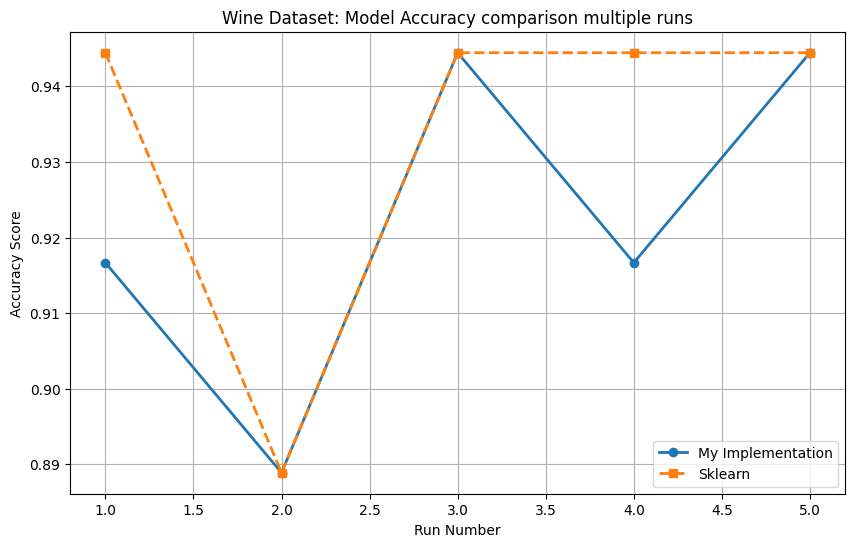

In [159]:
data_wine = pd.read_csv("wine.csv", header=2).to_numpy()

# TODO: Set up the data and split it into train and test-sets.
wine_train, wine_test = train_test_split(data_wine, test_size=0.2)

# TODO: Train and test your implemented tree model.
all_idxs = np.arange(len(wine_train))
X_train = wine_train[:,:-1]
y_train = wine_train[:,-1]
X_test = wine_test[:,:-1]
y_test = wine_test[:,-1]

tree = grow_tree(X_train, y_train, all_idxs, max_depth=5, task="classification")

predictions = []
for sample in X_test:
    pred = tree.predict(sample)
    predictions.append(pred)
predictions = np.array(predictions)

custom_acc = accuracy_score(y_test, predictions)
print(f"Test Run: Custom Tree Accuracy: {custom_acc:.4f}")


# NOTE: Use the same train/test split for your tree model and the scikit learn model
skl_classifier = DecisionTreeClassifier(criterion='gini', max_depth=5)
skl_fitted_classifier = skl_classifier.fit(X=X_train, y=y_train)
skl_predictions = skl_fitted_classifier.predict(X_test)
sk_learn_acc = accuracy_score(skl_predictions, y_test)
print(f"Test Run: Sklearn Tree Accuracy: {sk_learn_acc:.4f}")

# TODO: Do the above at least 5 times
# NOTE: Use loops here!
custom_acc, sk_learn_acc = [], []
for i in range(5):
    wine_train, wine_test = train_test_split(data_wine, test_size=0.2)
    X_train = wine_train[:,:-1]
    y_train = wine_train[:,-1]
    X_test = wine_test[:,:-1]
    y_test = wine_test[:,-1]

    tree = grow_tree(X_train, y_train, np.arange(len(wine_train)), max_depth=5, task="classification")
    predictions = [tree.predict(sample) for sample in X_test]
    custom_acc.append(accuracy_score(y_test, predictions))
    print(f"Run {i+1}: Custom Tree Accuracy: {custom_acc[-1]:.4f}")

    skl_classifier = DecisionTreeClassifier(criterion='gini', max_depth=5)
    skl_fitted_classifier = skl_classifier.fit(X=X_train, y=y_train)
    skl_predictions = skl_fitted_classifier.predict(X_test)
    sk_learn_acc.append(accuracy_score(skl_predictions, y_test))
    print(f"Run {i+1}: Sklearn Tree Accuracy: {sk_learn_acc[-1]:.4f}")

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(10, 6))

plt.plot(range(1, 6), custom_acc, marker='o', linestyle='-', label='My Implementation', linewidth=2)
plt.plot(range(1, 6), sk_learn_acc, marker='s', linestyle='--', label='Sklearn', linewidth=2)

plt.title('Wine Dataset: Model Accuracy comparison multiple runs')
plt.xlabel('Run Number')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)

plt.show()

### 7) Dataset 2: Heart Disease

Run 1: Custom Tree Accuracy: 0.8537
Run 1: Sklearn Tree Accuracy: 0.9024
Run 2: Custom Tree Accuracy: 0.8341
Run 2: Sklearn Tree Accuracy: 0.9073
Run 3: Custom Tree Accuracy: 0.8341
Run 3: Sklearn Tree Accuracy: 0.8634
Run 4: Custom Tree Accuracy: 0.8439
Run 4: Sklearn Tree Accuracy: 0.8927
Run 5: Custom Tree Accuracy: 0.8439
Run 5: Sklearn Tree Accuracy: 0.8927


/home/moritz/AiEngineering/MachineLearning/.venv/lib/python3.14/site-packages/numpy/_core/fromnumeric.py:4232: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/moritz/AiEngineering/MachineLearning/.venv/lib/python3.14/site-packages/numpy/_core/_methods.py:178: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/moritz/AiEngineering/MachineLearning/.venv/lib/python3.14/site-packages/numpy/_core/_methods.py:211: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/moritz/AiEngineering/MachineLearning/.venv/lib/python3.14/site-packages/numpy/_core/fromnumeric.py:4232: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/moritz/AiEngineering/MachineLearning/.venv/lib/python3.14/site-packages/numpy/_core/_methods.py:178: RuntimeWarning:

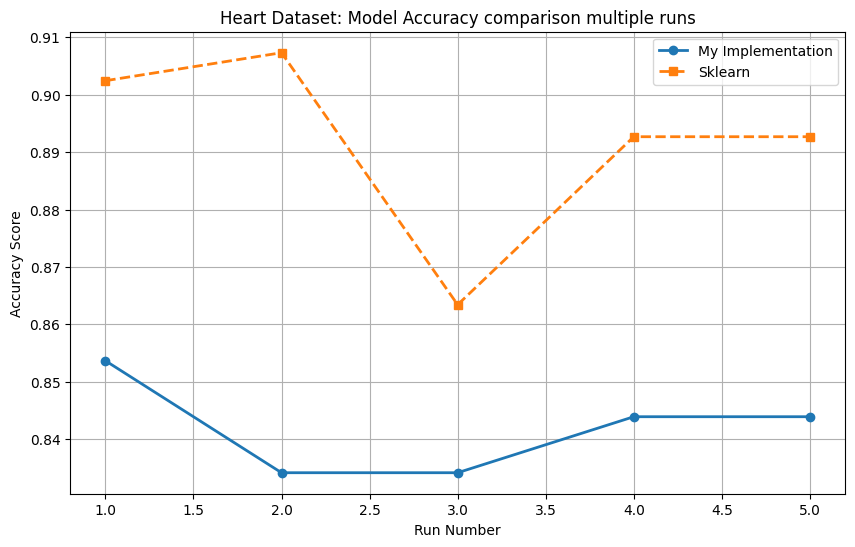

In [160]:
data_heart = pd.read_csv("heart.csv", header=1).to_numpy()

custom_acc, sk_learn_acc = [], []
for i in range(5):
    heart_train, heart_test = train_test_split(data_heart, test_size=0.2)
    X_train = heart_train[:,:-1]
    y_train = heart_train[:,-1]
    X_test = heart_test[:,:-1]
    y_test = heart_test[:,-1]
    tree = grow_tree(X_train, y_train, np.arange(len(heart_train)), max_depth=5, task="classification")
    predictions = [tree.predict(sample) for sample in X_test]
    custom_acc.append(accuracy_score(y_test, predictions))
    print(f"Run {i+1}: Custom Tree Accuracy: {custom_acc[-1]:.4f}")

    skl_classifier = DecisionTreeClassifier(criterion='gini', max_depth=5)
    skl_fitted_classifier = skl_classifier.fit(X=X_train, y=y_train)
    skl_predictions = skl_fitted_classifier.predict(X_test)
    sk_learn_acc.append(accuracy_score(skl_predictions, y_test))
    print(f"Run {i+1}: Sklearn Tree Accuracy: {sk_learn_acc[-1]:.4f}")

# Plot
plt.figure(figsize=(10, 6))

plt.plot(range(1, 6), custom_acc, marker='o', linestyle='-', label='My Implementation', linewidth=2)
plt.plot(range(1, 6), sk_learn_acc, marker='s', linestyle='--', label='Sklearn', linewidth=2)

plt.title('Heart Dataset: Model Accuracy comparison multiple runs')
plt.xlabel('Run Number')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)

plt.show()

### 8) Dataset 3: Car

Run 1: Custom Tree Accuracy: 0.8555
Run 1: Sklearn Tree Accuracy: 0.8439
Run 2: Custom Tree Accuracy: 0.8786
Run 2: Sklearn Tree Accuracy: 0.8786
Run 3: Custom Tree Accuracy: 0.8728
Run 3: Sklearn Tree Accuracy: 0.8699
Run 4: Custom Tree Accuracy: 0.8555
Run 4: Sklearn Tree Accuracy: 0.8555
Run 5: Custom Tree Accuracy: 0.8699
Run 5: Sklearn Tree Accuracy: 0.8699


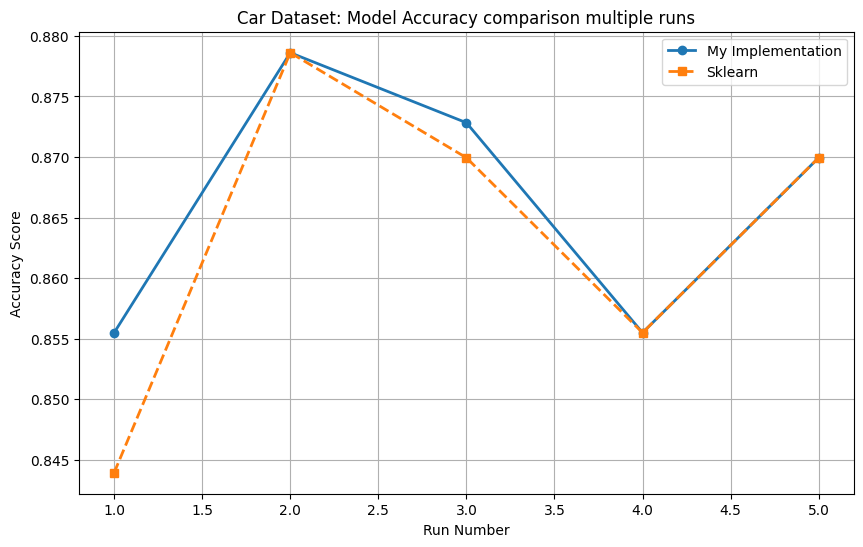

In [161]:
# Preprocessing necessary for the Car dataset (categorical features that sklearn cannot handle directly)

col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data_car = pd.read_csv("car.csv", header=None, names=col_names)

# Define the mappings based on the specific values in the Car dataset
# Assign numbers so they increase logically (small -> big, low -> high)
buying_maint_map = {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3}
doors_map        = {'2': 2, '3': 3, '4': 4, '5more': 5}
persons_map      = {'2': 2, '4': 4, 'more': 5}
lug_boot_map     = {'small': 0, 'med': 1, 'big': 2}
safety_map       = {'low': 0, 'med': 1, 'high': 2}
class_map        = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}

# Apply the mappings to the specific columns
data_car['buying']   = data_car['buying'].map(buying_maint_map)
data_car['maint']    = data_car['maint'].map(buying_maint_map)
data_car['doors']    = data_car['doors'].map(doors_map)
data_car['persons']  = data_car['persons'].map(persons_map)
data_car['lug_boot'] = data_car['lug_boot'].map(lug_boot_map)
data_car['safety']   = data_car['safety'].map(safety_map)

# Encode the target/label column
data_car['class']    = data_car['class'].map(class_map)

data_car.dropna(inplace=True)

X = data_car.drop('class', axis=1)
y = data_car['class']

custom_acc, sk_learn_acc = [], []
for i in range(5):
    car_train, car_test = train_test_split(np.hstack([X.values, y.values.reshape(-1, 1)]), test_size=0.2)
    X_train = car_train[:,:-1]
    y_train = car_train[:,-1]
    X_test = car_test[:,:-1]
    y_test = car_test[:,-1]
    tree = grow_tree(X_train, y_train, np.arange(len(car_train)), max_depth=5, task="classification")
    predictions = [tree.predict(sample) for sample in X_test]
    custom_acc.append(accuracy_score(y_test, predictions))
    print(f"Run {i+1}: Custom Tree Accuracy: {custom_acc[-1]:.4f}")

    skl_classifier = DecisionTreeClassifier(criterion='gini', max_depth=5)
    skl_fitted_classifier = skl_classifier.fit(X=X_train, y=y_train)
    skl_predictions = skl_fitted_classifier.predict(X_test)
    sk_learn_acc.append(accuracy_score(skl_predictions, y_test))
    print(f"Run {i+1}: Sklearn Tree Accuracy: {sk_learn_acc[-1]:.4f}")

# Plot
plt.figure(figsize=(10, 6))

plt.plot(range(1, 6), custom_acc, marker='o', linestyle='-', label='My Implementation', linewidth=2)
plt.plot(range(1, 6), sk_learn_acc, marker='s', linestyle='--', label='Sklearn', linewidth=2)

plt.title('Car Dataset: Model Accuracy comparison multiple runs')
plt.xlabel('Run Number')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)

plt.show()

### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

Run 1: Custom Tree Accuracy: 0.7222
Run 1: Preprocessed Tree Accuracy: 0.8889
Run 2: Custom Tree Accuracy: 0.9722
Run 2: Preprocessed Tree Accuracy: 0.9167
Run 3: Custom Tree Accuracy: 0.8889
Run 3: Preprocessed Tree Accuracy: 0.8056
Run 4: Custom Tree Accuracy: 0.8611
Run 4: Preprocessed Tree Accuracy: 0.8889
Run 5: Custom Tree Accuracy: 0.8333
Run 5: Preprocessed Tree Accuracy: 0.9167


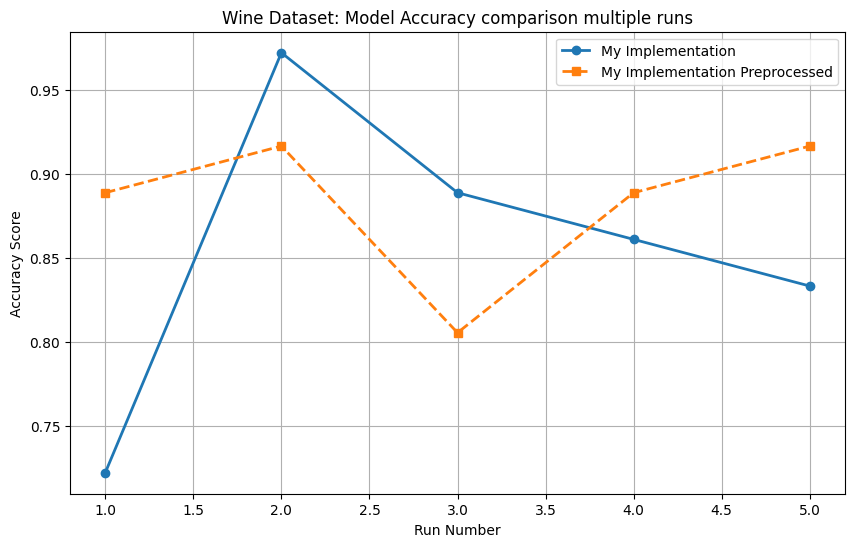

In [162]:
from sklearn import preprocessing

# TODO: Use the wine dataset from above and scale its features (Not the labels!) between 0 and 1
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(data_wine[:,:-1])
data_wine_scaled = np.hstack([X_scaled, data_wine[:,-1].reshape(-1, 1)])

custom_acc, custom_acc_pre = [], []
for i in range(5):
    # no preprocessing
    wine_train, wine_test = train_test_split(data_wine, test_size=0.2)
    X_train = wine_train[:,:-1]
    y_train = wine_train[:,-1]
    X_test = wine_test[:,:-1]
    y_test = wine_test[:,-1]

    tree = grow_tree(X_train, y_train, np.arange(len(wine_train)), max_depth=5, task="classification")
    predictions = [tree.predict(sample) for sample in X_test]
    custom_acc.append(accuracy_score(y_test, predictions))
    print(f"Run {i+1}: Custom Tree Accuracy: {custom_acc[-1]:.4f}")

    # preprocessed
    wine_train_pre, wine_test_pre = train_test_split(data_wine_scaled, test_size=0.2)
    X_train_pre = wine_train_pre[:,:-1]
    y_train_pre = wine_train_pre[:,-1]
    X_test_pre = wine_test_pre[:,:-1]
    y_test_pre = wine_test_pre[:,-1]

    tree_pre = grow_tree(X_train_pre, y_train_pre, np.arange(len(wine_train_pre)), max_depth=5, task="classification")
    predictions_pre = [tree_pre.predict(sample) for sample in X_test_pre]
    custom_acc_pre.append(accuracy_score(y_test_pre, predictions_pre))
    print(f"Run {i+1}: Preprocessed Tree Accuracy: {custom_acc_pre[-1]:.4f}")
    

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(10, 6))

plt.plot(range(1, 6), custom_acc, marker='o', linestyle='-', label='My Implementation', linewidth=2)
plt.plot(range(1, 6), custom_acc_pre, marker='s', linestyle='--', label='My Implementation Preprocessed', linewidth=2)

plt.title('Wine Dataset: Model Accuracy comparison multiple runs')
plt.xlabel('Run Number')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)

plt.show()

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is growing the tree indefinitely such a bad idea? The performance would increase would it not?

2) Beside preventing the tree from growing to large, what is the purpose of 'stopping criterias'?

3) What is the difference between **Information Entropy** and **Gini Impurity**?

4) What are some pros about using decision trees?

5) Did preprocessing the data help with performance when using decision trees?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!